In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
tf.enable_eager_execution()
import tensorflow.contrib.eager as tfe
import numpy as np
import sys
import os
from PIL import Image
import json
from sklearn.utils import shuffle
from cache import cache
import pydot
import graphviz
from sklearn.model_selection import train_test_split
import time
import pickle
from tqdm import tqdm
import copy
import re

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, LSTM, Embedding, Dropout,TimeDistributed, RepeatVector,\
Activation, Flatten, Reshape, concatenate, BatchNormalization

from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.applications.inception_v3 import preprocess_input as InceptionV3_preprocess_input
from tensorflow.python.keras.applications.vgg16 import preprocess_input as VGG16_preprocess_input
from tensorflow.python.keras.preprocessing import image

from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras.layers.merge import add
from tensorflow.python.keras.utils import to_categorical

In [3]:
tf.__version__

'1.14.0'

In [4]:
tf.keras.__version__

'2.2.4-tf'

In [5]:
tf.executing_eagerly()

True

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2094129271723807706
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5601869151572129046
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11020706929835403867
physical_device_desc: "device: XLA_GPU device"
]


In [7]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Download Data

In [8]:
os.path.abspath('.')

'/home/catnado/w266/final_project/Image_Caption'

In [9]:
# download caption file
if not os.path.exists(os.path.abspath('.') + '/annotations/'):
    annotation_zip = tf.keras.utils.get_file('captions.zip', 
                                              cache_subdir=os.path.abspath('.'),
                                              origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                              extract = True)
    annotation_file_train = os.path.abspath('.')+'/annotations/captions_train2014.json'
    annotation_file_val = os.path.abspath('.')+'/annotations/captions_val2014.json'
else:
    annotation_file_train = os.path.abspath('.')+'/annotations/captions_train2014.json'
    annotation_file_val = os.path.abspath('.')+'/annotations/captions_val2014.json'
    

In [10]:
print(annotation_file_train)
print(annotation_file_val)

/home/catnado/w266/final_project/Image_Caption/annotations/captions_train2014.json
/home/catnado/w266/final_project/Image_Caption/annotations/captions_val2014.json


In [11]:
# # download training set image file
# name_of_zip = 'train2014.zip'
# if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
#     image_zip = tf.keras.utils.get_file(name_of_zip,
#                                         cache_subdir=os.path.abspath('.') + '/train2014_try2/',
#                                         origin = 'http://images.cocodataset.org/zips/' + name_of_zip,
#                                         extract = True)
#     train_path = os.path.dirname(image_zip)+'/train2014/'
# else:
#     train_path = os.path.abspath('.')+'/train2014/'

In [12]:
train_path = os.path.abspath('.') + '/train2014/'
print(train_path)

/home/catnado/w266/final_project/Image_Caption/train2014/


In [13]:
# # download validation set image file
# name_of_zip = 'val2014.zip'
# if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
#     image_zip = tf.keras.utils.get_file(name_of_zip,
#                                         cache_subdir=os.path.abspath('.'),
#                                         origin = 'http://images.cocodataset.org/zips/' + name_of_zip,
#                                         extract = True)
#     val_path = os.path.dirname(image_zip)+'/val2014/'
# else:
#     val_path = os.path.abspath('.')+'/val2014/'

In [14]:
# print(train_path)
# print(val_path)

### Load data and limit size to 40,000

In [15]:
# Read the json file
with open(annotation_file_train, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = train_path + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

In [16]:
# # Shuffle captions and image_names together
# # Set a random state
# train_captions, img_name_vector = shuffle(all_captions,
#                                           all_img_name_vector,
#                                           random_state=1)

# # Select the first 30000 captions from the shuffled set
# num_examples = 40000
# train_captions = train_captions[:num_examples]
# img_name_vector = img_name_vector[:num_examples]

In [17]:
# len(train_captions), len(img_name_vector), len(all_captions)

### Load data and limit size to 40,000, but take only unique images and the first caption

In [18]:
# unique images with the first caption
unique_image_caption = dict(zip(all_img_name_vector, all_captions))
len(unique_image_caption)

82783

In [19]:
all_img_name_vector = list(unique_image_caption.keys())
all_captions = list(unique_image_caption.values())

In [20]:
# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 40000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [21]:
len(train_captions), len(img_name_vector), len(all_captions)

(40000, 40000, 82783)

### Full data

In [22]:
# # load training set
# with open(annotation_file_train, 'r') as f:
#     annotations = json.load(f)
    
# # storing the captions and the image name in vectorsa
# filenames_train = []
# captions_train = []

# for annot in annotations['annotations']:
#     caption = '<start> ' + annot['caption'] + ' <end>'
#     image_id = annot['image_id']
#     full_coco_image_path = train_path + 'COCO_train2014_' + '%012d.jpg' % (image_id)

#     filenames_train.append(full_coco_image_path)
#     captions_train.append(caption)
    
# unique_image_train = len(annotations['images'])

In [14]:
# # load validation set
# with open(annotation_file_val, 'r') as f:
#     annotations = json.load(f)
    
# # storing the captions and the image name in vectors
# filenames_val = []
# captions_val = []

# for annot in annotations['annotations']:
#     caption = '<start> ' + annot['caption'] + ' <end>'
#     image_id = annot['image_id']
#     full_coco_image_path = val_path + 'COCO_val2014_' + '%012d.jpg' % (image_id)

#     filenames_val.append(full_coco_image_path)
#     captions_val.append(caption)

# unique_image_val = len(annotations['images'])

In [21]:
# print("training set image: " + str(len(filenames_train)))
# print("training set unique image: " + str(unique_image_train))
# print("training set caption: " + str(len(captions_train)))

# print("validation set image: " + str(len(filenames_val)))
# print("validation set unique image: " + str(unique_image_val))
# print("validation set caption: " + str(len(captions_val)))

# Show Image

In [22]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [23]:
def show_image(path, caption):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    #path = filenames_train[idx]
    #caption = captions_train[idx]

    # Print the captions for this image.
    print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

<start> A train is pulling into a train station <end>


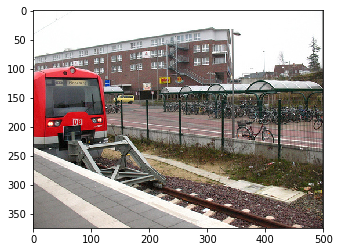

In [24]:
show_image(img_name_vector[8000], train_captions[8000])

# Encode Images with InceptionV3

### Encode with InceptionV3 layer[-3] for attention

In [19]:
# unique images
unique_images_train = sorted(set(filenames_train))
# unique_images_val = sorted(set(filenames_val))

In [23]:
# Get the InceptionV3 model trained on imagenet data
image_model2 = InceptionV3(weights='imagenet')
# Take -3 layer with shape (8,8,2048)
image_model_new2 = Model(image_model2.input, image_model2.layers[-3].output)

In [24]:
image_model_new2.output

<tf.Tensor 'mixed10/Identity:0' shape=(?, 8, 8, 2048) dtype=float32>

In [25]:
def load_image_for_inception(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = InceptionV3_preprocess_input(img)
    return img, image_path

In [41]:
# image_dataset = tf.data.Dataset.from_tensor_slices(unique_images_train)
# image_dataset = image_dataset.map(load_image_for_inception, 
#                                   num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

# for img, path in tqdm(image_dataset):
#     batch_features = image_model_new2(img)
#     batch_features = tf.reshape(batch_features,(tf.shape(batch_features)[0], -1, tf.shape(batch_features)[3]))

#     for bf, p in zip(batch_features, path):
#         path_of_feature = p.numpy().decode("utf-8")
#         np.save(path_of_feature, bf.numpy())
        
# # 82783 images, 64 batch size, expect 1294 batches

1294it [1:31:42,  3.66s/it]


In [21]:
# check loading image features
img_tensor = np.load(unique_images_train[-1]+'.npy')
img_tensor.shape

(64, 2048)

### For some reason some image features did not get saved. Rerunning for those images..

In [26]:
img_rerun = []
for img in unique_images_train:
    if not os.path.exists(img + '.npy'):
        img_rerun.append(img)

In [27]:
len(img_rerun)

4980

In [28]:
img_rerun[0]

'/home/catnado/w266/final_project/Image_Caption/train2014/COCO_train2014_000000116196.jpg'

In [29]:
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(img_rerun)
image_dataset = image_dataset.map(load_image_for_inception, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

for img, path in tqdm(image_dataset):
    batch_features = image_model_new2(img)
    batch_features = tf.reshape(batch_features,(tf.shape(batch_features)[0], -1, tf.shape(batch_features)[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())
        
# 82783 images, 64 batch size, expect 1294 batches

78it [05:24,  3.85s/it]


In [30]:
img_rerun = []
for img in unique_images_train:
    if not os.path.exists(img + '.npy'):
        img_rerun.append(img)
len(img_rerun)

0

# Tokenize

In [25]:
vocab_size = 8000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

word_index = {key:value for key, value in tokenizer.word_index.items() if value <= vocab_size}
word_index['<pad>'] = 0
vocab_size += 1
index_word = {value:key for key, value in word_index.items()}

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = pad_sequences(train_seqs, padding='post')

# max number of tokens
max_length = np.max([len(t) for t in train_seqs])

In [26]:
print(train_captions[0])
print(train_seqs[0])
print(cap_vector[0])
print('max length: ', max_length)

<start> A very thin cow standing near a herd of elephants. <end>
[3, 2, 139, 1449, 250, 20, 39, 2, 324, 7, 220, 4]
[   3    2  139 1449  250   20   39    2  324    7  220    4    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
max length:  48


# Split Data

In [68]:
# Splitting to training, validation, test sets with 30K, 5K, 5K respectively
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.25,
                                                                    random_state=0)

img_name_val, img_name_test, cap_val, cap_test = train_test_split(img_name_val,
                                                                    cap_val,
                                                                    test_size=0.5,
                                                                    random_state=0)

In [69]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val), len(img_name_test), len(cap_test)

(30000, 30000, 5000, 5000, 5000, 5000)

# GloVe Embedding

In [29]:
# download GloVe vectors
if not os.path.exists(os.path.abspath('.') + '/GloVe/'):
    glove_zip = tf.keras.utils.get_file('glove_6B.zip',
                                        cache_subdir=os.path.abspath('.' + '/GloVe/'),
                                        origin = 'https://nlp.stanford.edu/data/glove.6B.zip',
                                        extract = True)

In [30]:
# Load Glove vectors
glove_dir = os.path.abspath('.' + '/GloVe/')
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [31]:
embedding_dim = 200
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [32]:
embedding_matrix.shape

(8001, 200)

# Inject Model with Attention

### Create a tf.data dataset for training

In [33]:
img_name_train = img_name_train[:29952] #[:256]
cap_train = cap_train[:29952] #[:256]

In [34]:
len(img_name_train), len(cap_train)

(256, 256)

In [35]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 200
units = 512
vocab_size = vocab_size
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [36]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [37]:
# test on 1000 images first
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Model

In [38]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [39]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [50]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, embedding_matrix):
        super(RNN_Decoder, self).__init__()
        self.units = units

        # self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # use glove embeddings - this works too
        # self.embed_matrix = tfe.Variable(embedding_matrix, trainable=False, dtype=tf.float32)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                   trainable=False)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.softmax = tf.keras.layers.Softmax()
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        # x = tf.nn.embedding_lookup(self.embed_matrix, x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)
        
        # softmax
        x = self.softmax(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [51]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size, embedding_matrix)

### Optimizer and loss function

In [52]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Checkpoint

In [53]:
checkpoint_path = "./checkpoints/attention_inject_GloVe/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [54]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1]) * 5

In [55]:
start_epoch

0

### Restoring from Checkpoint

In [39]:
# restore from latest checkpoint
ckpt.restore(ckpt_manager.latest_checkpoint)
if ckpt_manager.latest_checkpoint:
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/attention_inject/ckpt-4


In [40]:
ckpt_manager.checkpoints

['./checkpoints/attention_inject/ckpt-1',
 './checkpoints/attention_inject/ckpt-2',
 './checkpoints/attention_inject/ckpt-3',
 './checkpoints/attention_inject/ckpt-4']

In [45]:
# ckpt.restore(ckpt_manager.checkpoints[2])
# if ckpt_manager.checkpoints[2]:
#     print("Restored from {}".format(ckpt_manager.checkpoints[2]))
# else:
#     print("Initializing from scratch.")

### Training

In [56]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [57]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [58]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if (epoch+1) % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.1240
Epoch 1 Loss 2.176614
Time taken for 1 epoch 382.6680221557617 sec

Epoch 2 Batch 0 Loss 2.1239
Epoch 2 Loss 2.175745
Time taken for 1 epoch 8.726491689682007 sec

Epoch 3 Batch 0 Loss 2.1063
Epoch 3 Loss 2.147913
Time taken for 1 epoch 8.604909420013428 sec

Epoch 4 Batch 0 Loss 2.0921
Epoch 4 Loss 2.144118
Time taken for 1 epoch 8.776548147201538 sec

Epoch 5 Batch 0 Loss 2.0921
Epoch 5 Loss 2.144118
Time taken for 1 epoch 8.818664073944092 sec



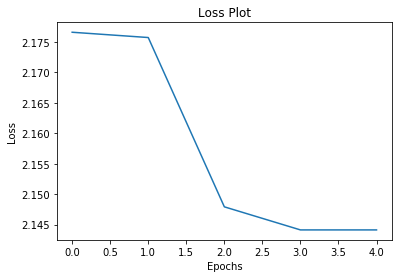

In [67]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Generate Caption

In [41]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(max(3, len_result//2), max(2, len_result//2), l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [42]:
def greedy_search(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    img_tensor_val = np.load(image+'.npy')
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [43]:
def beam_search(image, k):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    img_tensor_val = np.load(image+'.npy')
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([word_index['<start>']], 0)
      
    seq = [0] * max_length
    seq[0] = word_index['<start>']
    prob = 0
    all_candidates = [(seq, prob, hidden, attention_plot)]
    current_candidates = []

    for count in range(max_length-1):
        for i in range(len(all_candidates)):
            seq, prob, hidden, attention_plot = all_candidates[i]
            attention_plot = copy.deepcopy(attention_plot)
            dec_input = tf.expand_dims([seq[count]], 0)
            
            # if previously predicted <end>, do not make more prediction, add the current values to current_candidate
            if word_index['<end>'] in set(seq):
                current_candidates.extend([all_candidates[i]])
            
            else:
                predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
                attention_plot[count] = tf.reshape(attention_weights, (-1, )).numpy()

                predictions = predictions[0].numpy()
                pred_word = np.argsort(predictions)[-k:][::-1]
                pred_prob = predictions[pred_word]

                pred_prob = (prob*count + pred_prob)/(count+1)
                pred_seq = []
                for word in pred_word:
                    seq2 = copy.deepcopy(seq)
                    seq2[count+1] = word
                    pred_seq.append(seq2)

                pred_hidden = [hidden] *k
                pred_att_plot = [attention_plot] *k

                current_candidates.extend(zip(pred_seq, pred_prob, pred_hidden, pred_att_plot))
        
        #print(count)
        ordered = sorted(current_candidates, key=lambda tup:tup[1], reverse=True)
        all_candidates = ordered[:k]
        current_candidates = []
        count += 1
        

    # final result
    ordered = sorted(all_candidates, key=lambda tup:tup[1], reverse=True)
    result = ordered[0][0]
    attention_plot = ordered[0][3]
    result = [index_word[i] for i in result if i != 0]
    result = result[1:]
    #result = ' '.join(result)

    return result, attention_plot

True Caption: <start> a close up of a pizza on a black surface <end>
Predicted Caption: there is an image of pizzas that is being cooked <end>


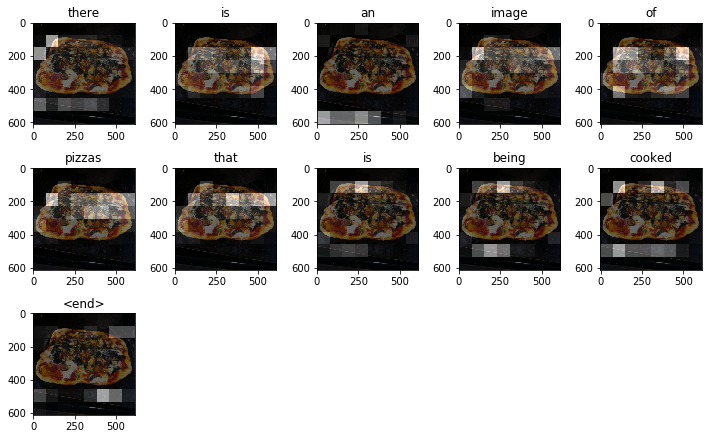

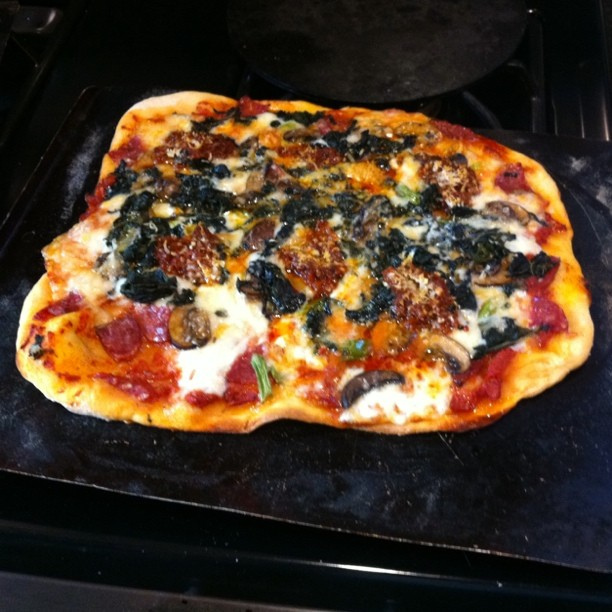

In [44]:
# caption with beam search
img = 14
image = img_name_val[img]
true_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[img] if i not in [0]])
result, attention_plot = beam_search(image, 3)
print ('True Caption:', true_caption)
print ('Predicted Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(img_name_val[img])

True Caption: <start> a close up of a pizza on a black surface <end>
Predicted Caption: a pizza with cheese and cheese and cheese and cheese <end>


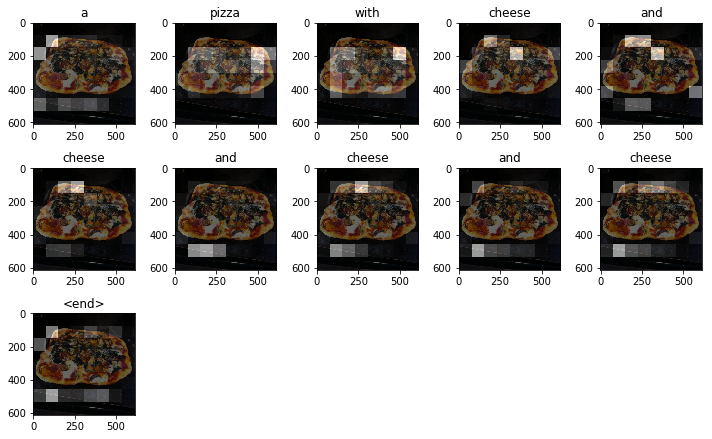

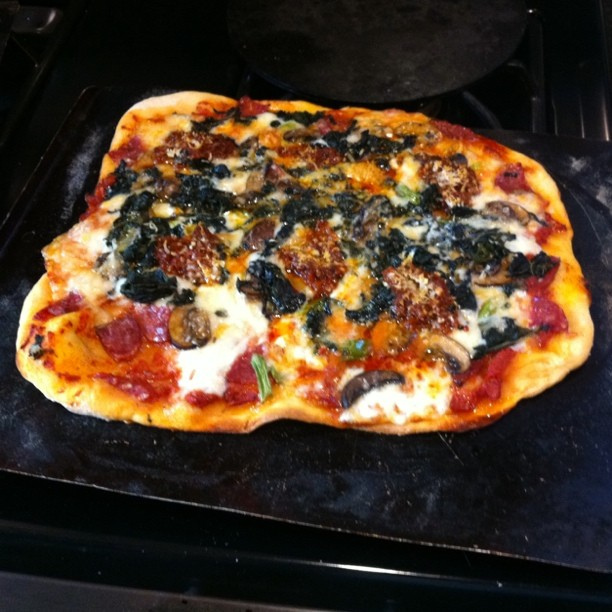

In [53]:
# caption with greedy search
img = 14
image = img_name_val[img]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[img] if i not in [0]])
result, attention_plot = greedy_search(image)
print ('True Caption:', real_caption)
print ('Predicted Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(img_name_val[img])

# Generate Caption for Entire Test Set

In [45]:
# same greedy search without generating attention_plot to save some space/time
def caption_greedy(image):
    hidden = decoder.reset_state(batch_size=1)
    img_tensor_val = np.load(image+'.npy')
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if index_word[predicted_id] == '<end>':
            return ' '.join(result[:-1])

        dec_input = tf.expand_dims([predicted_id], 0)

    return ' '.join(result[:-1])

In [46]:
caption_greedy(image)

'a pizza with cheese and cheese and cheese and cheese'

In [47]:
# same beam search without generating attention_plot to save some space/time
def caption_beam(image, k):
    hidden = decoder.reset_state(batch_size=1)
    img_tensor_val = np.load(image+'.npy')
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([word_index['<start>']], 0)
      
    seq = [0] * max_length
    seq[0] = word_index['<start>']
    prob = 0
    all_candidates = [(seq, prob, hidden)]
    current_candidates = []

    for count in range(max_length-1):
        for i in range(len(all_candidates)):
            seq, prob, hidden = all_candidates[i]
            dec_input = tf.expand_dims([seq[count]], 0)
            
            # if previously predicted <end>, do not make more prediction, add the current values to current_candidate
            if word_index['<end>'] in set(seq):
                current_candidates.extend([all_candidates[i]])
            
            else:
                predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
                predictions = predictions[0].numpy()
                pred_word = np.argsort(predictions)[-k:][::-1]
                pred_prob = predictions[pred_word]

                pred_prob = (prob*count + pred_prob)/(count+1)
                pred_seq = []
                for word in pred_word:
                    seq2 = copy.deepcopy(seq)
                    seq2[count+1] = word
                    pred_seq.append(seq2)

                pred_hidden = [hidden] *k
                
                current_candidates.extend(zip(pred_seq, pred_prob, pred_hidden))
        
        #print(count)
        ordered = sorted(current_candidates, key=lambda tup:tup[1], reverse=True)
        all_candidates = ordered[:k]
        current_candidates = []
        count += 1
        

    # final result
    ordered = sorted(all_candidates, key=lambda tup:tup[1], reverse=True)
    result = ordered[0][0]
    result = [index_word[i] for i in result if i != 0]
    result = result[1:-1]
    result = ' '.join(result)

    return result

In [48]:
caption_beam(image, 3)

'there is an image of pizzas that is being cooked'

### Save true captions

In [122]:
true_caption = []
for sentence in cap_test:
    caption = ' '.join([index_word[token] for token in sentence if token not in [0, 1, 3, 4, 474]])
    # clean up true captions.. there are a few that contains \n
    caption = re.sub('\n', '', caption)
    true_caption.append(caption)

In [123]:
len(true_caption)

5000

In [129]:
true_caption[:10]

['a man jumping over a gate while riding a horse',
 'dirty old truck stick in traffic on a cloudy day',
 'two guys are playing with the wii together',
 'a girl on a ladder next to a tree in an apple orchard',
 'a baseball player drops his bat and prepares to run',
 'a boat decorated in a brightly painted fish passing another boat in a harbor',
 'blurry image of a person reaching into fridge',
 'a man riding on the back of a motorcycle',
 'a man carries a child and poses for a picture',
 'two horses standing in the snow side by side in front of a building']

In [124]:
true_caption[3897]

'breakfast on a plate with utensils and drinks'

In [125]:
with open('evaluation/true_caption.txt', 'w') as f:
    for i in true_caption:
        f.write("%s\n" % i)

In [126]:
!wc -l evaluation/true_caption.txt

5000 evaluation/true_caption.txt


### Generate greedy search captions

In [49]:
pred_caption = []
for i in range(len(img_name_test)):
    caption = caption_greedy(img_name_test[i])
    caption = re.sub('\n', '', caption)
    pred_caption.append(caption)

In [50]:
len(pred_caption)

5000

In [51]:
pred_caption[:10]

['a man with a plane',
 'a truck with a crane on a dark blue skies',
 'a group of people playing videogames with a woman standing in a room',
 'a man standing in his face',
 'a man is swinging a baseball player in a stadium',
 'a small boat boat in the water',
 'a man is standing in a kitchen',
 'a motorcycle parked on a street',
 'a small child is sitting in a dark room',
 'a man is a horse is lying on a snowy ground']

In [52]:
with open('evaluation/attention_inject_greedy.txt', 'w') as f:
    for i in pred_caption:
        f.write("%s\n" % i)

In [53]:
!wc -l evaluation/attention_inject_greedy.txt

5000 evaluation/attention_inject_greedy.txt


### Generate beam search captions

In [142]:
start_time = time.time()
pred_caption = []
for i in range(len(img_name_test)):
    caption = caption_beam(img_name_test[i], 3)
    caption = re.sub('\n', '', caption)
    pred_caption.append(caption)
elapsed_time = time.time() - start_time
print("Time taken in min:", elapsed_time/60)

Time taken in min: 84.22254472176233


In [143]:
len(pred_caption)

5000

In [144]:
pred_caption[:10]

['an old photograph of two men stand in the middle of an open field',
 'there is an older pickup truck parked next to a parking lot',
 'there is a group of girls are playing videogames with letter headphones playing games together',
 'there is an older man standing next to each other',
 'a baseball player quickly slides into the stadium playing baseball game',
 'there is a small boat boat in the water',
 'a man is standing in the kitchen',
 'two motorcycles are riding down the side of a road',
 'a small child is sitting next to each other',
 'two men are sitting on the sun']

In [145]:
with open('evaluation/attention_inject_beam_3.txt', 'w') as f:
    for i in pred_caption:
        f.write("%s\n" % i)

In [146]:
!wc -l evaluation/attention_inject_beam_3.txt

5000 evaluation/attention_inject_beam_3.txt


# Evaluation

In [147]:
from nlgeval import compute_metrics
from nlgeval import compute_individual_metrics

In [150]:
metrics_dict = compute_metrics(hypothesis='evaluation/attention_inject_greedy.txt',
                               references=['evaluation/true_caption.txt'])

Bleu_1: 0.204437
Bleu_2: 0.106926
Bleu_3: 0.057249
Bleu_4: 0.030627
METEOR: 0.104801
ROUGE_L: 0.262289
CIDEr: 0.415262
SkipThoughtsCosineSimilairty: 0.485033
EmbeddingAverageCosineSimilairty: 0.821234
VectorExtremaCosineSimilarity: 0.493658
GreedyMatchingScore: 0.654735


In [151]:
metrics_dict = compute_metrics(hypothesis='evaluation/attention_inject_beam_3.txt',
                               references=['evaluation/true_caption.txt'])

Bleu_1: 0.165575
Bleu_2: 0.084267
Bleu_3: 0.045135
Bleu_4: 0.023885
METEOR: 0.095490
ROUGE_L: 0.217637
CIDEr: 0.343418
SkipThoughtsCosineSimilairty: 0.446801
EmbeddingAverageCosineSimilairty: 0.811784
VectorExtremaCosineSimilarity: 0.472642
GreedyMatchingScore: 0.628802


# End of Main Code

### Debug stuff

In [321]:
image = img_name_train[0]
attention_plot = np.zeros((max_length, attention_features_shape))
hidden = decoder.reset_state(batch_size=1)
img_tensor_val = np.load(image+'.npy')
features = encoder(img_tensor_val)
dec_input = tf.expand_dims([word_index['<start>']], 0)

seq = [0] * max_length
seq[0] = word_index['<start>']
prob = 0
all_candidates = [(seq, prob, hidden, attention_plot)]
current_candidates = []

In [426]:
# for count in range(max_length)
count = 3

In [454]:
# for i in range(len(all_candidates)):
i = 2

In [455]:
seq, prob, hidden, attention_plot = all_candidates[i]
dec_input = tf.expand_dims([seq[count]], 0)

In [457]:
predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
attention_plot[count] = tf.reshape(attention_weights, (-1, )).numpy()

In [458]:
predictions = predictions[0].numpy()
pred_word = np.argsort(predictions)[-3:][::-1]
pred_word

array([  2, 430,  56])

In [459]:
predictions

array([-9.61376 ,  7.605274, 12.695165, ..., -9.915413, -9.927469,
       -9.098779], dtype=float32)

In [460]:
pred_prob = predictions[pred_word]
pred_prob

array([12.695165, 11.364677, 11.135266], dtype=float32)

In [461]:
pred_prob = (prob*count + pred_prob)/(count+1)
pred_prob

array([15.506205, 15.173583, 15.11623 ], dtype=float32)

In [462]:
pred_seq = []
for word in pred_word:
    seq2 = copy.deepcopy(seq)
    seq2[count+1] = word
    pred_seq.append(seq2)

In [463]:
pred_hidden = [hidden] *3
pred_att_plot = [attention_plot] *3

In [464]:
current_candidates.extend(zip(pred_seq, pred_prob, pred_hidden, pred_att_plot))

In [465]:
len(current_candidates)

7

In [466]:
# end of i loop

In [467]:
ordered = sorted(current_candidates, key=lambda tup:tup[1], reverse=True)
all_candidates = ordered[:3]
current_candidates = []
#count += 1

In [468]:
len(all_candidates)

3

# Inject Model

In [ ]:
state_size = 512
embedding_size = 128

# encoder
encoder_input = Input(shape=(transfer_values_size,), name='encoder_input')
encoder_output = Dense(state_size, activation='tanh', name='encoder_output') 
# using tanh to get to -1 to 1 in order to use as initial state

# decoder
decoder_input = Input(shape=(None, ), name='decoder_input')
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_size, name='decoder_embedding')
decoder_gru1 = GRU(state_size, return_sequences=True, name='decoder_gru1')
decoder_gru2 = GRU(state_size, return_sequences=True, name='decoder_gru2')
decoder_gru3 = GRU(state_size, return_sequences=True, name='decoder_gru3')
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_output')

# connect layers
initial_state = encoder_output(encoder_input)
net = decoder_embedding(decoder_input)
net = decoder_gru1(net, initial_state=initial_state)
net = decoder_gru2(net, initial_state=initial_state)
net = decoder_gru3(net, initial_state=initial_state)
decoder_output = decoder_dense(net)


# connect and create model
model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_output)


In [ ]:
print(model.summary())

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# checkpoint
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
callback_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# tensorboard
callback_tensorboard = TensorBoard(log_dir='./tensorboard_logs/', histogram_freq=0, write_graph=False)

callbacks = [callback_checkpoint, callback_tensorboard]

In [ ]:
# load model
try:
    model.load_weights(filepath)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
# compile model
rms = RMSprop(lr=0.001)  #RMS prop works better than adam for RNN models
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=rms)


In [ ]:
check_X1train = 

In [ ]:
# fit model
# should train for 20, try 1 for now
%time
model.fit([check_X1train, check_X2train], check_ytrain, epochs=3, verbose=2, callbacks=callbacks, 
          validation_data=([check_X1val, check_X2val], check_yval))

# Generate Caption

In [ ]:
def generate_caption(idx, max_tokens=51):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # input X1: transfer values
    transfer_values = X1train[idx].reshape((1, 4096))
    
    # input X2: word token
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    token_int = tokenizer.word_index['<start>']
    token_end = tokenizer.word_index['<end>']
    output_text = ''
    count_tokens = 0


    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        
        decoder_input_data[0, count_tokens] = token_int
        decoder_output = model.predict([transfer_values, decoder_input_data])
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)
        if token_int != 0:
            sampled_word = index_word[token_int]
            output_text += " " + sampled_word
        else:
            break
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    show_image(idx)
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()